In [1]:
import pandas as pd, numpy as np, os, string
from itertools import product
from sklearn.metrics import f1_score
from scipy.stats import spearmanr, pointbiserialr
import matplotlib.pyplot as plt  
import seaborn as sns

In [2]:
# Define the datasets and models
datasets = ["covid-lies", "election", "phemerumours", "semeval", "srq", "wtwt"]
models = ["falcon-40b-instruct", "falcon-7b-instruct", "flan-alpaca-gpt4-xl", "flan-alpaca-xxl", "Llama-2-13b-chat-hf", 
          "Mistral-7B-Instruct-v0.1", "flan-ul2", "Llama-2-7b-chat-hf", "Llama-2-7b-hf", "phi-2"]
prompts = ['task_only', 'task_and_definition', 'context_analyze', 'context_question', 'few_shot', 'zero_shot_cot', 'coda']

In [3]:
def post_process_results(results):
    """
    This function post-processes the results from a large language model to label text.

    Args:
        results (list): A list of strings, each string is a word from language model output.

    Returns:
        list: A list of strings, each string is a classification label ('disagree', 'neutral', 'agree').
    """

    # A list to store the prediction labels
    y_pred = []  

    # Words or phrases that indicate each stance category
    disagree_indicators = ['against', 'denies', 'critical', 'deny', 'neg', 'oppose', 'opposes']
    agree_indicators = ['support','supports', 'for', 'pro ', 'positive', 'agree', 'agrees']
    neutral_indicators = ['neutral', 'unrelated']

    # Iterate over LLM return in the results
    for word in results:  
        # Normalize the word to lower case and remove leading/trailing white spaces
        normalized_word = str(word).strip().lower()

        if any(indicator in normalized_word for indicator in disagree_indicators):
            # If the word is also found in agree_indicators or neutral_indicators, label it as 'neutral'
            if any(indicator in normalized_word for indicator in agree_indicators) or any(indicator in normalized_word for indicator in neutral_indicators):
                y_pred.append('neutral')
            else:
                y_pred.append('disagree')
        elif any(indicator in normalized_word for indicator in neutral_indicators):
            # If the word is also found in disagree_indicators or agree_indicators, label it as 'neutral'
            if any(indicator in normalized_word for indicator in disagree_indicators) or any(indicator in normalized_word for indicator in agree_indicators):
                y_pred.append('neutral')
            else:
                y_pred.append('neutral')
        elif any(indicator in normalized_word for indicator in agree_indicators):
            # If the word is also found in disagree_indicators or neutral_indicators, label it as 'neutral'
            if any(indicator in normalized_word for indicator in disagree_indicators) or any(indicator in normalized_word for indicator in neutral_indicators):
                y_pred.append('neutral')
            else:
                y_pred.append('agree')
        else:  
            # If no specific stance label is found, label it as 'neutral'
            y_pred.append('neutral')


    return y_pred

In [4]:
# List of stance indicators words
disagree_indicators = ['against', 'denies', 'critical', 'deny', 'neg', 'oppose', 'opposes']
agree_indicators = ['support','supports', 'for', 'pro ', 'positive', 'agree', 'agrees']
neutral_indicators = ['neutral', 'unrelated']

stance_words = disagree_indicators + agree_indicators + neutral_indicators

# Function to count words, excluding specified words for single-word entries
def count_noninformative_words(entry):
    return sum(1 for word in str(entry).strip().split() if word.lower().strip(string.punctuation) not in stance_words)

# Function to check if the entry has at least one word from each indicator list, but only from one list
def has_stance_prediction(entry):
    entry_words = set(word.lower().strip(string.punctuation) for word in str(entry).strip().split())
    
    # Check if there's at least one word from each indicator list
    disagree_present = any(word in entry_words for word in disagree_indicators)
    agree_present = any(word in entry_words for word in agree_indicators)
    neutral_present = any(word in entry_words for word in neutral_indicators)
    
    # Count the number of indicator lists that have at least one word present in the entry
    present_counts = sum(1 for present in [disagree_present, agree_present, neutral_present] if present)
    
    # If only one indicator list has words present in the entry, return 1, otherwise return 0
    return 1 if present_counts == 1 else 0

# Calculate F1 scores for Zero-shot Results
__note__: I am using the 'unweighted' F1 scores and calculating across all three labels (i.e., positive, negative, and neutral). I am also going to store the median in number of words for then raw output as well.

In [5]:
# Initialize an empty dataframe to store F1-scores
f1_scores_df = pd.DataFrame(index=datasets, columns=pd.MultiIndex.from_product([models, prompts], names=['model', 'prompt']))
f1_scores_by_model_df = pd.DataFrame(index=models, columns=pd.MultiIndex.from_product([datasets, prompts], names=['dataset', 'prompt']))
median_words_df = pd.DataFrame(index=models, columns=pd.MultiIndex.from_product([datasets, prompts], names=['dataset', 'prompt']))

In [6]:
# Loop through each dataset and model
for dataset, model in product(datasets, models):
    # Read the CSV file
    file_path = f"results/{dataset}_{model}.csv"
    df = pd.read_csv(file_path)

    # Loop through each column and calculate correlation
    for column, raw_column in zip(['task_only_preds_0', 'task_and_definition_preds_0', 'context_analyze_preds_0', 'context_question_preds_0', 'few_shot_preds_0', 'zero_shot_cot_preds_0', 'coda_preds_0'],
                                  ['task_only_preds_raw_0', 'task_and_definition_preds_raw_0', 'context_analyze_preds_raw_0', 'context_question_preds_raw_0', 'few_shot_preds_raw_0', 'zero_shot_cot_preds_raw_0', 'coda_preds_raw_0']):
        try:
            # redoing the post-processing of the raw results
            df[column] = post_process_results(df[raw_column])
            # computing the F1 score
            f1 = f1_score(df['stance'], df[column], average='macro')
        except KeyError:
            f1 = np.nan

        try:
            median_words_raw = df[raw_column].apply(lambda x: len(str(x).strip().split()))
            median_words = median_words_raw.median()
        except KeyError:
            median_words = np.nan
        
        f1_scores_df.loc[dataset, (model, column.split('_preds')[0])] = f1
        f1_scores_by_model_df.loc[model, (dataset, column.split('_preds')[0])] = f1
        median_words_df.loc[model, (dataset, column.split('_preds')[0])] = median_words

In [7]:
f1_scores_df

model        falcon-40b-instruct                                      \
prompt                 task_only task_and_definition context_analyze   
covid-lies              0.196631            0.191212        0.234796   
election                0.380838            0.406054        0.484859   
phemerumours            0.159803            0.153745        0.159972   
semeval                 0.401694            0.401734        0.599097   
srq                     0.305951            0.310373        0.385807   
wtwt                    0.539425            0.557631        0.531276   

model                                                            \
prompt       context_question  few_shot zero_shot_cot      coda   
covid-lies           0.288622  0.246564      0.355068       NaN   
election             0.438996  0.512709      0.474722       NaN   
phemerumours          0.22236  0.137471      0.203428       NaN   
semeval              0.584115  0.524961      0.436589  0.410238   
srq                  0.391426  0.373239      0.405426       NaN   
wtwt                  0.54478  0.403267      0.386157       NaN   

model        falcon-7b-instruct                                      ...  \
prompt                task_only task_and_definition context_analyze  ...   
covid-lies             0.323352            0.313294        0.140956  ...   
election               0.178101            0.260732        0.265847  ...   
phemerumours           0.225401            0.264841        0.130998  ...   
semeval                0.222491            0.241796         0.24663  ...   
srq                    0.220031            0.255272        0.361927  ...   
wtwt                   0.308776            0.318017        0.149442  ...   

model        Llama-2-7b-hf                        phi-2                      \
prompt            few_shot zero_shot_cot coda task_only task_and_definition   
covid-lies        0.336816      0.225644  NaN  0.316868            0.296516   
election          0.244535      0.327754  NaN  0.278925            0.239919   
phemerumours      0.244644       0.18829  NaN  0.236442            0.274534   
semeval           0.189192      0.305298  NaN  0.261252            0.212069   
srq               0.330498       0.33441  NaN  0.240322            0.274657   
wtwt              0.350102      0.295728  NaN  0.325198            0.324138   

model                                                                  \
prompt       context_analyze context_question  few_shot zero_shot_cot   
covid-lies          0.285955         0.151933  0.273572      0.323743   
election            0.279928         0.298043  0.333847      0.322283   
phemerumours        0.102631          0.07145  0.245065      0.190333   
semeval             0.256996         0.285165  0.242326      0.303272   
srq                  0.30714         0.336304  0.283417      0.350159   
wtwt                0.367478         0.289018  0.392047       0.37378   

model                   
prompt            coda  
covid-lies    0.307368  
election      0.237517  
phemerumours  0.231331  
semeval       0.257768  
srq           0.250462  
wtwt          0.321982  

[6 rows x 70 columns]

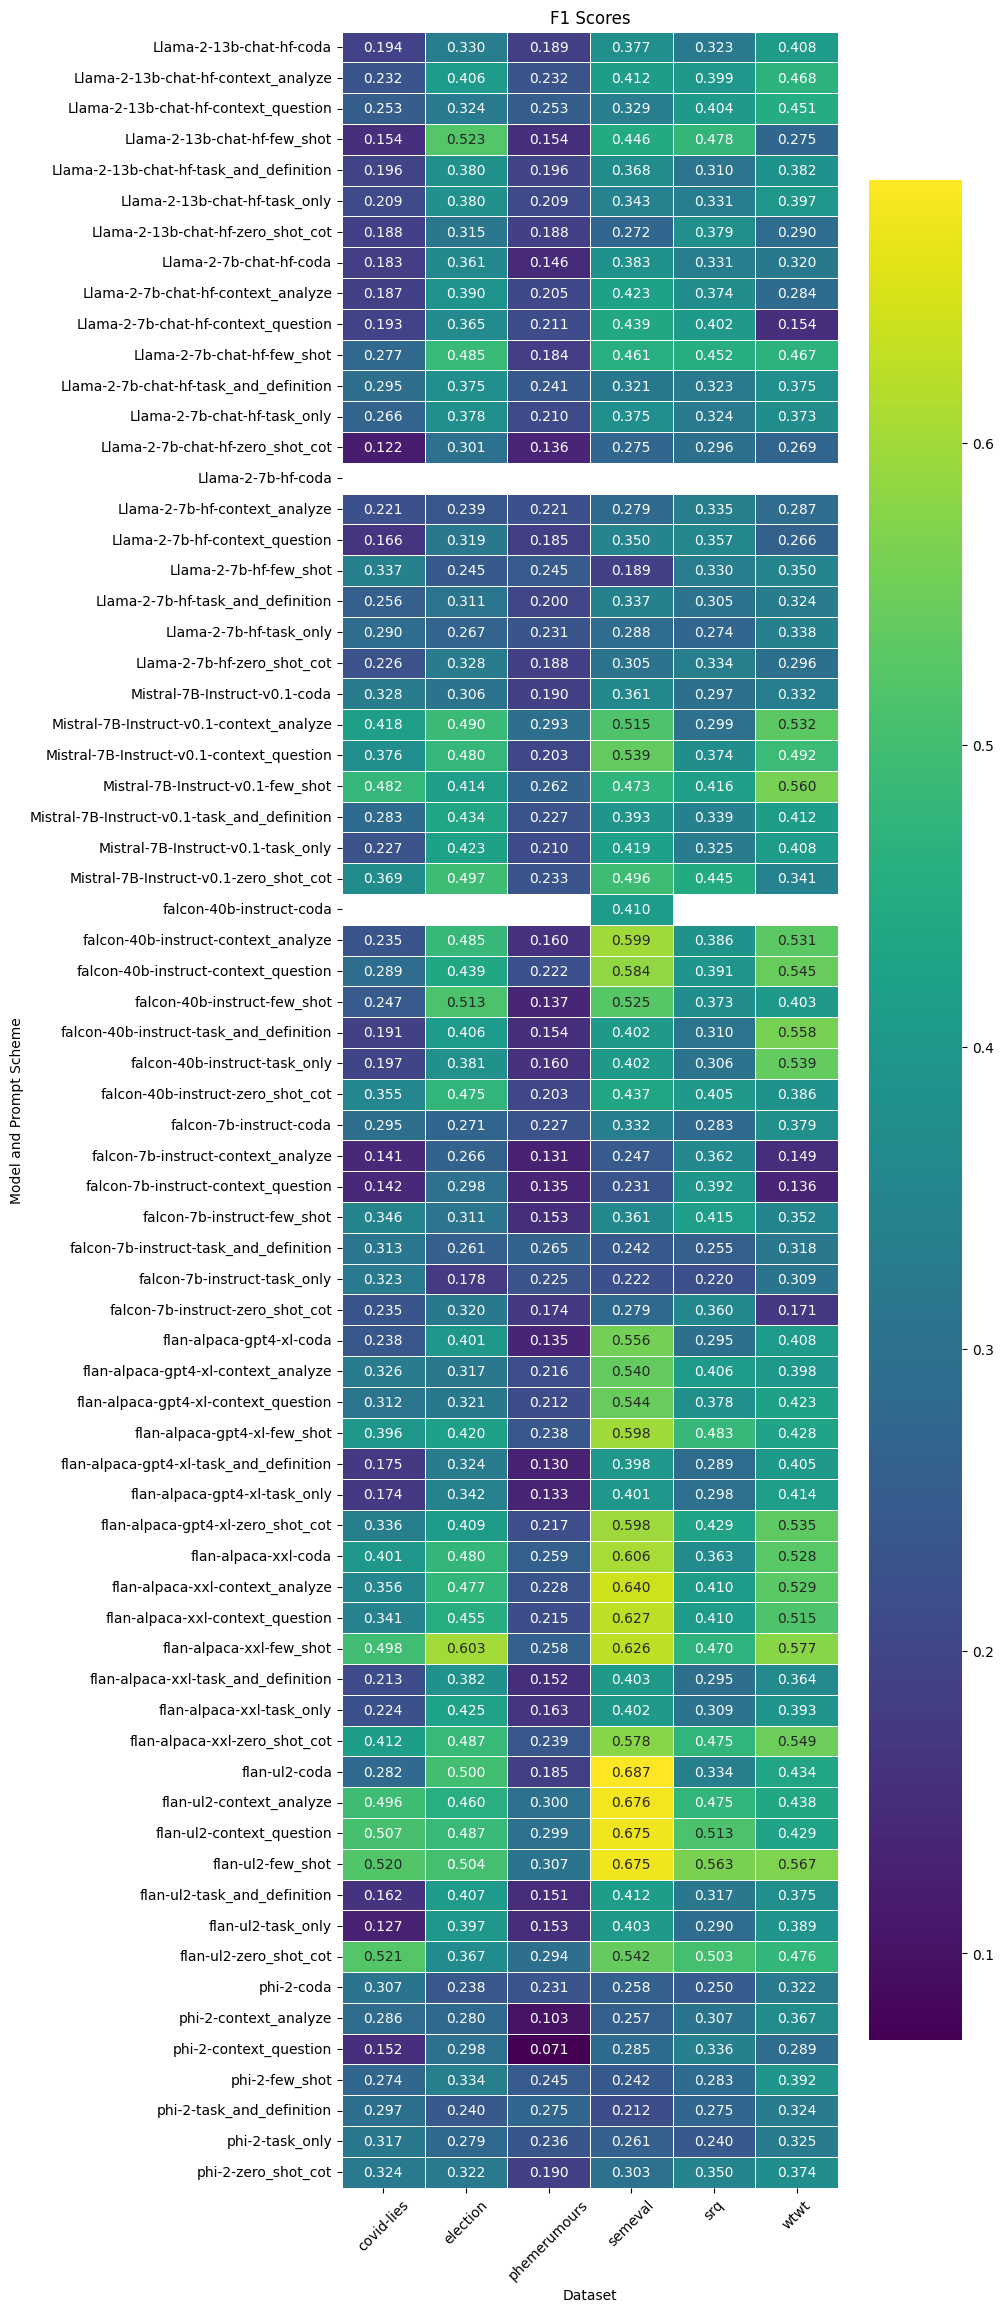

In [34]:
# Print a rotated heatmap
plt.figure(figsize=(8, 28))
f1_scores_df = f1_scores_df.sort_index(axis=1, level=[0, 1])
heatmap = sns.heatmap(f1_scores_df.astype(float).T, annot=True, cmap='viridis', fmt=".3f", linewidths=.5)
plt.title('F1 Scores')
plt.xlabel('Dataset')
plt.ylabel('Model and Prompt Scheme')
plt.xticks(rotation=45)
plt.show()

In [9]:
output_csv_path = "zero-shot_stance_labeling_f1-scores_04MAR24.csv"
f1_scores_df.to_csv(output_csv_path)

# Analyze the relationship between raw output length and the quality of the produced labels

In [10]:
median_words_df

dataset                  covid-lies                                      \
prompt                    task_only task_and_definition context_analyze   
falcon-40b-instruct             7.0                 7.0            12.0   
falcon-7b-instruct              1.0                 1.0             1.0   
flan-alpaca-gpt4-xl             1.0                 1.0             1.0   
flan-alpaca-xxl                 1.0                 1.0             1.0   
Llama-2-13b-chat-hf             1.0                20.0            27.0   
Mistral-7B-Instruct-v0.1        1.0                 1.0             1.0   
flan-ul2                        1.0                 1.0             1.0   
Llama-2-7b-chat-hf              1.0                17.0             3.0   
Llama-2-7b-hf                  23.0                22.0            18.0   
phi-2                          18.0                20.0            26.0   

dataset                                                                 \
prompt                   context_question few_shot zero_shot_cot  coda   
falcon-40b-instruct                  14.0     11.0          11.0   NaN   
falcon-7b-instruct                    1.0      1.0           1.0   1.0   
flan-alpaca-gpt4-xl                   1.0      1.0           1.0   1.0   
flan-alpaca-xxl                       1.0      1.0           1.0   1.0   
Llama-2-13b-chat-hf                  29.0      1.0           4.0   1.0   
Mistral-7B-Instruct-v0.1              1.0      1.0           1.0  15.0   
flan-ul2                              1.0      1.0           1.0   1.0   
Llama-2-7b-chat-hf                    6.0      1.0           1.0   3.0   
Llama-2-7b-hf                        18.0     30.0          21.0   NaN   
phi-2                                25.0     25.0          26.0  22.0   

dataset                   election                                      ...  \
prompt                   task_only task_and_definition context_analyze  ...   
falcon-40b-instruct            9.0                 7.0            12.0  ...   
falcon-7b-instruct             1.0                 1.0             1.0  ...   
flan-alpaca-gpt4-xl            1.0                 1.0             1.0  ...   
flan-alpaca-xxl                1.0                 1.0             1.0  ...   
Llama-2-13b-chat-hf            1.0                24.0            17.0  ...   
Mistral-7B-Instruct-v0.1       1.0                 1.0             1.0  ...   
flan-ul2                       1.0                 1.0             1.0  ...   
Llama-2-7b-chat-hf             1.0                17.0            14.0  ...   
Llama-2-7b-hf                 22.0                22.0            16.0  ...   
phi-2                          2.0                21.0            30.0  ...   

dataset                       srq                          wtwt  \
prompt                   few_shot zero_shot_cot  coda task_only   
falcon-40b-instruct           5.0           7.0   NaN       7.0   
falcon-7b-instruct            1.0           1.0   1.0       1.0   
flan-alpaca-gpt4-xl           1.0           1.0   1.0       1.0   
flan-alpaca-xxl               1.0           1.0   1.0       1.0   
Llama-2-13b-chat-hf           1.0           4.0   1.0       1.0   
Mistral-7B-Instruct-v0.1      1.0           1.0   1.0       1.0   
flan-ul2                      1.0           1.0   1.0       1.0   
Llama-2-7b-chat-hf            1.0           1.0   1.0       3.0   
Llama-2-7b-hf                30.0          20.0   NaN      22.0   
phi-2                        18.0          25.0  24.0      20.0   

dataset                                                                        \
prompt                   task_and_definition context_analyze context_question   
falcon-40b-instruct                      7.0            14.0             12.0   
falcon-7b-instruct                       1.0             1.0              1.0   
flan-alpaca-gpt4-xl                      1.0             1.0              1.0   
flan-alpaca-xxl                          1.0       

In [11]:
print("Average response length (number of words):")
median_words_df.mean(axis=1)

Average response length (number of words):


falcon-40b-instruct          9.567568
falcon-7b-instruct           1.595238
flan-alpaca-gpt4-xl               1.0
flan-alpaca-xxl                   1.0
Llama-2-13b-chat-hf         11.654762
Mistral-7B-Instruct-v0.1     2.714286
flan-ul2                          1.0
Llama-2-7b-chat-hf           7.404762
Llama-2-7b-hf               20.972222
phi-2                       22.047619
dtype: object

In [12]:
# Calculate the ratio of F1 score to median output length for each dataset and column
ratio_df = f1_scores_by_model_df / median_words_df

# Calculate the average ratio for each model
average_ratio_df = pd.DataFrame(index=models, columns=['Average Ratio'])

for model in models:
    model_ratios = ratio_df.loc[model].values.flatten()
    average_ratio = np.nanmean(model_ratios)  # Use np.nanmean to handle NaN values
    average_ratio_df.loc[model, 'Average Ratio'] = average_ratio

# Print or use the average_ratio_df as needed
print("Average Ratios:")
print(average_ratio_df)

Average Ratios:
                         Average Ratio
falcon-40b-instruct            0.04141
falcon-7b-instruct            0.241744
flan-alpaca-gpt4-xl           0.357031
flan-alpaca-xxl               0.412817
Llama-2-13b-chat-hf           0.144979
Mistral-7B-Instruct-v0.1      0.356316
flan-ul2                      0.419001
Llama-2-7b-chat-hf             0.14658
Llama-2-7b-hf                 0.013713
phi-2                         0.016133


## Analysis of the response length versus the reponse quality
- create a dataframe that denotes response length, wether the response was correct, and response length of non-stance words
- look at the correlations between the response lengths and the correctness of the output
- see if we can build an ML mopdel for predicting wether the LLM was correct given its response

In [13]:
# Initialize an empty DataFrame to store the long-format data
long_df = pd.DataFrame(columns=['model', 'dataset', 'prompt_scheme', 'correct', 'num_words'])

# Loop through each dataset and model
for dataset, model in product(datasets, models):
    # Read the CSV file
    file_path = f"results/{dataset}_{model}.csv"
    df = pd.read_csv(file_path)

    # Loop through each column and populate long_df
    for column, raw_column in zip(['task_only_preds_0', 'task_and_definition_preds_0', 'context_analyze_preds_0', 'context_question_preds_0', 'few_shot_preds_0', 'zero_shot_cot_preds_0', 'coda_preds_0'],
                                  ['task_only_preds_raw_0', 'task_and_definition_preds_raw_0', 'context_analyze_preds_raw_0', 'context_question_preds_raw_0', 'few_shot_preds_raw_0', 'zero_shot_cot_preds_raw_0', 'coda_preds_raw_0']):
        prompt_scheme = column.split('_preds')[0]
        
        try:
            # redoing the post-processing of the raw results
            df[column] = post_process_results(df[raw_column])
            
            # Calculate number of words in raw column
            num_words = df[raw_column].apply(lambda x: len(str(x).strip().split()))
            num_noninformative_words = df[raw_column].apply(lambda x: count_noninformative_words(str(x).strip()))
            has_stance_pred = df[raw_column].apply(lambda x: has_stance_prediction(str(x).strip()))
        except KeyError:
            num_words = np.nan
            num_noninformative_words = np.nan
            has_stance_pred = np.nan
        
        try:
            # Create a temporary DataFrame for this prompt scheme
            temp_df = pd.DataFrame({
                'model': model,
                'dataset': dataset,
                'prompt_scheme': prompt_scheme,
                'correct': (df['stance'] == df[column]).astype(int),
                'num_words': num_words,
                'num_noninformative_words': num_noninformative_words,
                'has_stance_pred': has_stance_pred,
                'raw_output': df[raw_column]
            })
        except KeyError:
            continue
        
        # Concatenate the temporary DataFrame to long_df
        long_df = pd.concat([long_df, temp_df], ignore_index=True)

In [14]:
long_df.shape

(7717170, 8)

In [15]:
long_df.head()

,model,dataset,prompt_scheme,correct,num_words,num_noninformative_words,has_stance_pred,raw_output
0,falcon-40b-instruct,covid-lies,task_only,0,7,6.0,1.0,"\nThe stance of the statement is ""for""."
1,falcon-40b-instruct,covid-lies,task_only,0,7,6.0,1.0,"\nThe stance of the statement is ""for""."
2,falcon-40b-instruct,covid-lies,task_only,1,7,6.0,1.0,"\nThe stance of the statement is ""neutral""."
3,falcon-40b-instruct,covid-lies,task_only,0,17,15.0,1.0,against\nThe statement is against the spread ...
4,falcon-40b-instruct,covid-lies,task_only,0,17,15.0,1.0,against\nThe statement is against the spread ...


### Calculate correlation between response length and correct response
- calculate including all predictions
- claculate including only those that have a stance word

In [16]:
# Calculate correlation between "correct" and "num_words" along with the p-value
correlation, p_value = spearmanr(long_df['correct'], long_df['num_words'])

# Print or use the correlation value and p-value
print(f"Correlation between 'correct' and 'num_words': {correlation}")
print(f"P-value: {p_value}")

Correlation between 'correct' and 'num_words': 0.001220645274232932
P-value: 0.0006965633694596524


In [17]:
# Calculate correlation between "correct" and "num_noninformative_words" along with the p-value
correlation, p_value = spearmanr(long_df['correct'], long_df['num_noninformative_words'])

# Print or use the correlation value and p-value
print(f"Correlation between 'correct' and 'num_words': {correlation}")
print(f"P-value: {p_value}")

Correlation between 'correct' and 'num_words': 0.003094664342374141
P-value: 8.187458628396813e-18


In [18]:
# Calculate correlation between "correct" and "any_stance_pred" along with the p-value
correlation, p_value = pointbiserialr(long_df['correct'], long_df['has_stance_pred'])

# Print or use the correlation value and p-value
print(f"Point-biserial correlation between 'correct' and 'has_stance_pred': {correlation}")
print(f"P-value: {p_value}")

Point-biserial correlation between 'correct' and 'has_stance_pred': -0.06964289123637714
P-value: 0.0


#### Without non-stance word outputs

In [19]:
# Calculate correlation between "correct" and "num_words" along with the p-value
correlation, p_value = spearmanr(long_df[long_df['has_stance_pred']==1]['correct'], long_df[long_df['has_stance_pred']==1]['num_words'])

# Print or use the correlation value and p-value
print(f"Correlation between 'correct' and 'num_words': {correlation}")
print(f"P-value: {p_value}")

Correlation between 'correct' and 'num_words': -0.018174761259932642
P-value: 0.0


In [20]:
# Calculate correlation between "correct" and "num_noninformative_words" along with the p-value
correlation, p_value = spearmanr(long_df[long_df['has_stance_pred']==1]['correct'], long_df[long_df['has_stance_pred']==1]['num_noninformative_words'])

# Print or use the correlation value and p-value
print(f"Correlation between 'correct' and 'num_words': {correlation}")
print(f"P-value: {p_value}")

Correlation between 'correct' and 'num_words': -0.015865705383755896
P-value: 0.0


### Analyze bad outputs

In [21]:
# Calculate the percentage of entries where 'any_stance_pred' is 1 for all entries
total_percentage = (long_df['has_stance_pred'].sum() / len(long_df)) * 100

# Calculate the percentage of entries where 'any_stance_pred' is 1 for each unique combination of 'model' and 'prompt_scheme'
response_ratio_per_group = long_df.groupby(['model', 'prompt_scheme'])['has_stance_pred'].mean()
correct_ratio_per_group = long_df.groupby(['model', 'prompt_scheme'])['correct'].mean().astype("float64")
response_percentage_df = response_ratio_per_group.reset_index().pivot(index='model', columns='prompt_scheme', values='has_stance_pred') *100
correct_percentage_df = correct_ratio_per_group.reset_index().pivot(index='model', columns='prompt_scheme', values='correct') *100

# Print the results
print("Percentage of entries where there is a stance entry for all entries:", total_percentage)

Percentage of entries where there is a stance entry for all entries: 92.84464382668777


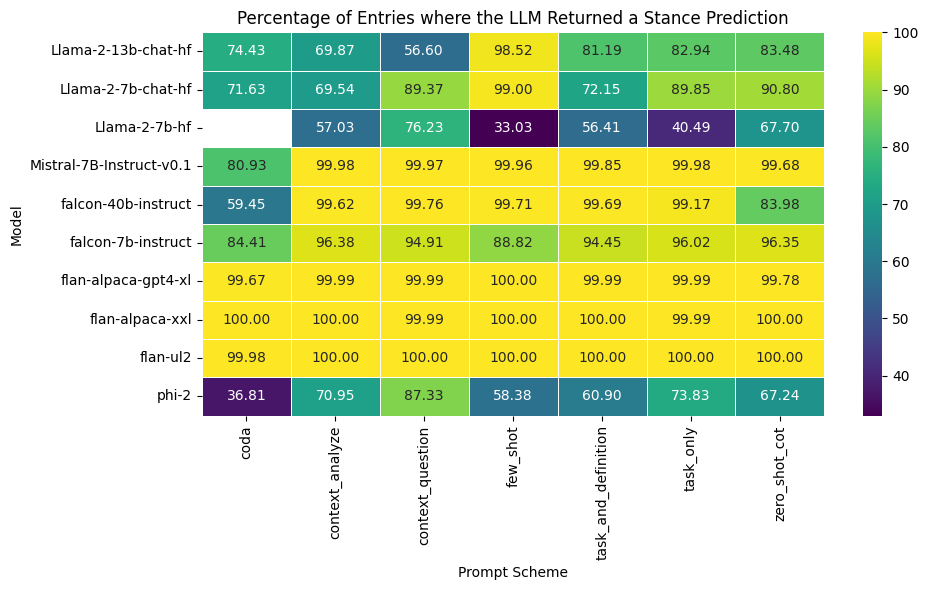

In [22]:
# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(response_percentage_df, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title("Percentage of Entries where the LLM Returned a Stance Prediction")
plt.xlabel("Prompt Scheme")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

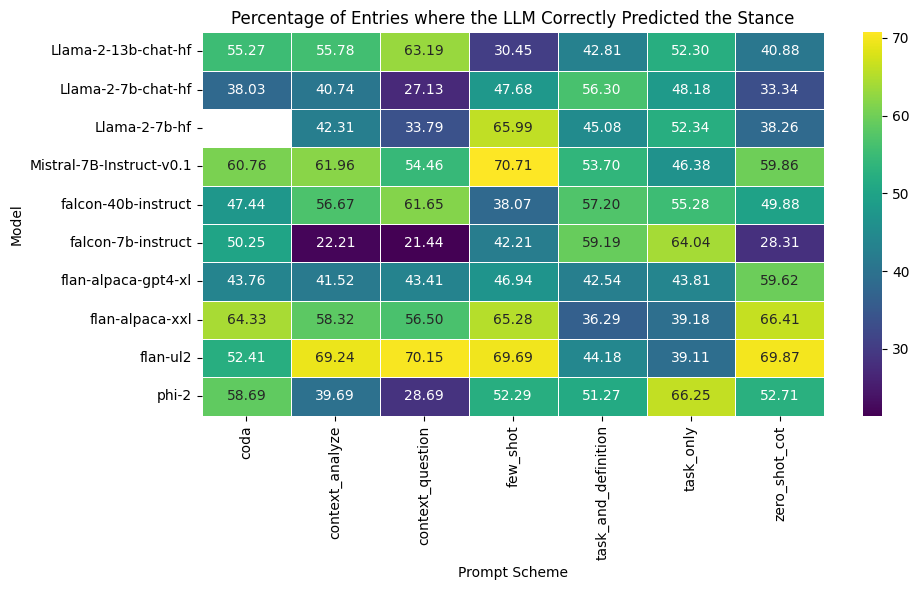

In [23]:
# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correct_percentage_df, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title("Percentage of Entries where the LLM Correctly Predicted the Stance")
plt.xlabel("Prompt Scheme")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

In [24]:
filtered_long_df = long_df[long_df['has_stance_pred']==1]
total_correct_percentage = (filtered_long_df['correct'].sum() / len(filtered_long_df)) * 100

correct_ratio_per_group_with_response = filtered_long_df.groupby(['model', 'prompt_scheme'])['correct'].mean().astype("float64")
correct_percentage_with_response_df = correct_ratio_per_group_with_response.reset_index().pivot(index='model', columns='prompt_scheme', values='correct') *100

# Print the results
print("Percentage of entries correct when there was a stance prediction:", total_correct_percentage)

Percentage of entries correct when there was a stance prediction: 50.81645040411145


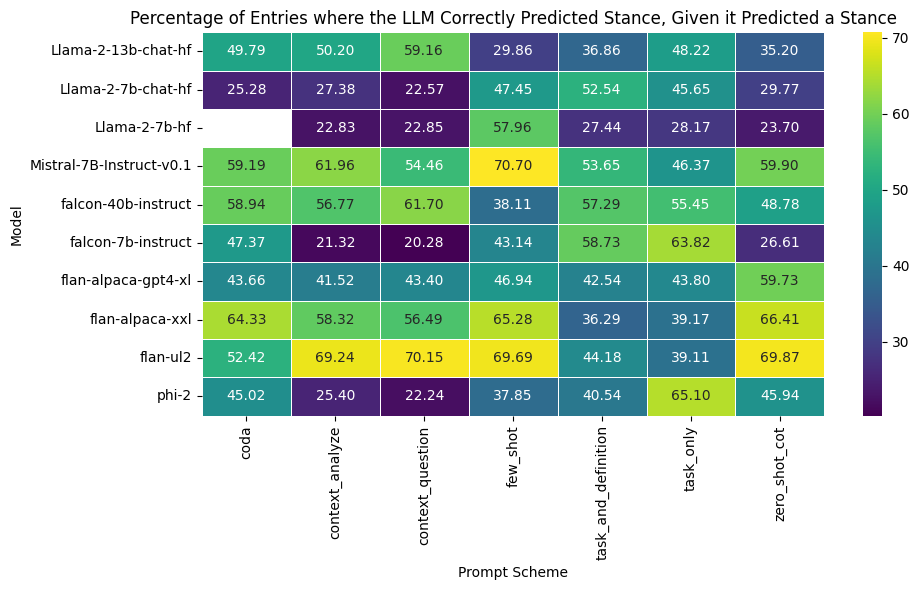

In [25]:
# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correct_percentage_with_response_df, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title("Percentage of Entries where the LLM Correctly Predicted Stance, Given it Predicted a Stance")
plt.xlabel("Prompt Scheme")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

In [26]:
response_percentage_df.to_csv("zero-shot_stance_labeling_good_outputs_04MAR24.csv")

### Attempt a simple machine learning model that gives an prediction on a model being correct, given its output
- do one for all outputs
- do one for just outputs that have a valid stance

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

labels = np.array(long_df['correct']).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    long_df[['model', 'prompt_scheme', 'num_words', 'num_noninformative_words', 'has_stance_pred']],
    labels,
    test_size=0.2
)

# Create a pipeline for preprocessing and modeling
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',  OneHotEncoder(), ['model', 'prompt_scheme']),
        #('num', StandardScaler(), ['num_words', 'num_noninformative_words'])
    ],
    remainder='passthrough'
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(min_samples_split=0.2))
])

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)


Accuracy: 0.5907042348425653
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.46      0.52    744771
           1       0.59      0.71      0.64    798663

    accuracy                           0.59   1543434
   macro avg       0.59      0.59      0.58   1543434
weighted avg       0.59      0.59      0.58   1543434



In [28]:
labels = np.array(filtered_long_df['correct']).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    filtered_long_df[['model', 'prompt_scheme', 'num_words', 'num_noninformative_words']],
    labels,
    test_size=0.2
)

# Create a pipeline for preprocessing and modeling
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',  OneHotEncoder(), ['model', 'prompt_scheme']),
        #('num', StandardScaler(), ['num_words', 'num_noninformative_words'])
    ],
    remainder='passthrough'
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(min_samples_split=0.2))
])

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)


Accuracy: 0.5867245965794741
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.49      0.54    704157
           1       0.58      0.68      0.63    728839

    accuracy                           0.59   1432996
   macro avg       0.59      0.59      0.58   1432996
weighted avg       0.59      0.59      0.58   1432996



# Calculate F1 scores for the Fine-tuned Model Results
__note__: I am using the 'unweighted' F1 scores and calculating across all three labels (i.e., positive, negative, and neutral).

In [29]:
# Loop through each dataset and model
f1_scores = {}
for dataset in ["semeval", "election", "pheme", "covid", "srq", "wtwt"]:
    for model in ["flan-alpaca-xxl", "flan-ul2", "Mistral-7B-Instruct-v0.1", "Llama-2-7b-hf"]:
        # Read the CSV file
        file_path = f"fine_tuned_results/{dataset}_{model}_fine_tuned_results.csv"
        df = pd.read_csv(file_path)

        if dataset == "srq":
            df['stance'] = post_process_results(df['train_stance'])
        
        df['finetuned_test_pred'] = post_process_results(df['finetuned_pred_raw'])
        f1 = f1_score(df['stance'], df['finetuned_test_pred'], average='macro')

        # Add F1 score to the dictionary
        if model in f1_scores:
            f1_scores[model][dataset] = f1
        else:
            f1_scores[model] = {dataset: f1}

fine_tuned_f1_scores_df = pd.DataFrame.from_dict(f1_scores, orient='index')

In [30]:
fine_tuned_f1_scores_df 

,semeval,election,pheme,covid,srq,wtwt
flan-alpaca-xxl,0.189974,0.294390,0.354952,0.404251,0.327497,0.321887
flan-ul2,0.468453,0.434648,0.207563,0.271106,0.410926,0.396781
Mistral-7B-Instruct-v0.1,0.445975,0.458036,0.453666,0.409577,0.178953,0.529516
Llama-2-7b-hf,0.285479,0.331596,0.341721,0.343366,0.353249,0.318615


In [31]:
fine_tuned_f1_scores_df.to_csv("fine_tuned_stance_labeling_f1-scores_04MAR24.csv")

## Analyze the prompt responses for quality

In [74]:
# Initialize an empty DataFrame to store the long-format data
fine_tuned_long_df = pd.DataFrame(columns=['model', 'dataset', 'correct', 'num_words'])

# Loop through each dataset and model
for dataset, model in product(["semeval", "election", "pheme", "covid", "srq", "wtwt"], 
                              ["flan-alpaca-xxl", "flan-ul2", "Mistral-7B-Instruct-v0.1", "Llama-2-7b-hf"]):
    # Read the CSV file
    file_path = f"fine_tuned_results/{dataset}_{model}_fine_tuned_results.csv"
    df = pd.read_csv(file_path)
        
    num_words = df['finetuned_pred_raw'].apply(lambda x: len(str(x).strip().split()))
    num_noninformative_words = df['finetuned_pred_raw'].apply(lambda x: count_noninformative_words(str(x).strip()))
    has_stance_pred = df['finetuned_pred_raw'].apply(lambda x: has_stance_prediction(str(x).strip()))

    df['finetuned_test_pred'] = post_process_results(df['finetuned_pred_raw'])

    temp_df = pd.DataFrame({
        'model': model,
        'dataset': dataset,
        'correct': (df['stance'] == df['finetuned_test_pred']).astype(int),
        'num_words': num_words,
        'num_noninformative_words': num_noninformative_words,
        'has_stance_pred': has_stance_pred,
        'raw_output': df['finetuned_pred_raw']
    })
        
    # Concatenate the temporary DataFrame to long_df
    fine_tuned_long_df = pd.concat([fine_tuned_long_df, temp_df], ignore_index=True)

In [75]:
fine_tuned_long_df.shape

(191524, 7)

In [76]:
fine_tuned_long_df.head()

,model,dataset,correct,num_words,num_noninformative_words,has_stance_pred,raw_output
0,flan-alpaca-xxl,semeval,1,1,0.0,1.0,against
1,flan-alpaca-xxl,semeval,0,1,0.0,1.0,for
2,flan-alpaca-xxl,semeval,0,1,0.0,1.0,for
3,flan-alpaca-xxl,semeval,0,1,0.0,1.0,for
4,flan-alpaca-xxl,semeval,0,1,0.0,1.0,for


### Analyze bad outputs

In [77]:
# Calculate the percentage of entries where 'any_stance_pred' is 1 for all entries
total_percentage = (fine_tuned_long_df['has_stance_pred'].sum() / len(fine_tuned_long_df)) * 100

# Calculate the percentage of entries where 'any_stance_pred' is 1 for each unique combination of 'model' and 'prompt_scheme'
response_ratio_per_group = fine_tuned_long_df.groupby(['model'])['has_stance_pred'].mean()
correct_ratio_per_group = fine_tuned_long_df.groupby(['model'])['correct'].mean().astype("float64")
response_percentage_df = response_ratio_per_group *100
correct_percentage_df = correct_ratio_per_group *100

# Print the results
print("Percentage of entries where there is a stance entry for all entries:", total_percentage)

Percentage of entries where there is a stance entry for all entries: 90.43618554332616


In [78]:
response_percentage_df

model
Llama-2-7b-hf               67.364926
Mistral-7B-Instruct-v0.1    99.995823
flan-alpaca-xxl             94.494685
flan-ul2                    99.889309
Name: has_stance_pred, dtype: float64

In [79]:
correct_percentage_df

model
Llama-2-7b-hf               51.602932
Mistral-7B-Instruct-v0.1    59.825400
flan-alpaca-xxl             31.837263
flan-ul2                    36.335916
Name: correct, dtype: float64

In [80]:
filtered_fine_tuned_long_df = fine_tuned_long_df[fine_tuned_long_df['has_stance_pred']==1]
total_correct_percentage = (filtered_fine_tuned_long_df['correct'].sum() / len(filtered_fine_tuned_long_df)) * 100

correct_ratio_per_group_with_response = filtered_fine_tuned_long_df.groupby(['model'])['correct'].mean().astype("float64")
correct_percentage_with_response_df = correct_ratio_per_group_with_response *100

# Print the results
print("Percentage of entries correct when there was a stance prediction:", total_correct_percentage)

Percentage of entries correct when there was a stance prediction: 43.16569191776314


In [81]:
correct_percentage_with_response_df

model
Llama-2-7b-hf               42.560843
Mistral-7B-Instruct-v0.1    59.827899
flan-alpaca-xxl             33.205879
flan-ul2                    36.315547
Name: correct, dtype: float64

In [82]:
response_percentage_df.to_csv("fine_tuned_stance_labeling_good_outputs_27FEB24.csv")